In [3]:
# MENTAL HEALTH CHATBOT WITH SUICIDE DETECTION

# Import Libraries
import numpy as np
import pandas as pd
import re
import string
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from joblib import dump, load

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Custom Preprocessing Classes ---

# A custom TextPreprocessor class for cleaning text.
# The spacy dependency for lemmatization has been removed to resolve environment errors.
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_attribute):
        self.text_attribute = text_attribute

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        # Convert the specified text attribute to string type
        X_copy[self.text_attribute] = X_copy[self.text_attribute].astype(str)
        return X_copy[self.text_attribute].apply(self._preprocess_text)

    def _preprocess_text(self, text):
        # Step 1: Clean the text by removing special symbols and email artifacts
        cleaned_text = self._clean(text)
        # Step 2: Keep only alphabetic letters and convert to lowercase
        letters_only_text = self._leave_letters_only(cleaned_text).lower()
        return letters_only_text

    def _clean(self, text):
        bad_symbols = '!\"#%&\'*+,-<=>?[\\]^_`{|}~'
        text_without_symbols = text.translate(str.maketrans('', '', bad_symbols))

        text_without_bad_words = ''
        for line in text_without_symbols.split('\n'):
            if not line.lower().startswith('from:') and not line.lower().endswith('writes:'):
                text_without_bad_words += line + '\n'

        clean_text = text_without_bad_words
        email_regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
        regexes_to_remove = [email_regex, r'Subject:', r'Re:']
        for r in regexes_to_remove:
            clean_text = re.sub(r, '', clean_text)

        return clean_text

    def _leave_letters_only(self, text):
        text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
        return ' '.join(re.findall("[a-zA-Z]+", text_without_punctuation))

# A transformer to convert a sparse matrix to a dense numpy array.
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

# --- Utility Functions ---

def plot_confusion_matrix_with_labels(y_true, y_pred, labels, title='Confusion Matrix'):
    """Function to plot a confusion matrix using sklearn's ConfusionMatrixDisplay."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

def evaluate_model_with_cv(model, X_train_data, y_train_data, X_test_data, y_test_data):
    """
    Evaluates a model's performance using 5-fold cross-validation on the training set
    and displays the classification report and confusion matrix on the test set.
    """
    print(f"Performing 5-fold cross-validation on the training set for {model.__class__.__name__}...")
    scores = cross_val_score(model, X_train_data, y_train_data, cv=5, scoring='accuracy', n_jobs=-1)

    print(f"Cross-validation scores: {scores}")
    print("Mean Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    print(f"\nEvaluating {model.__class__.__name__} on the held-out test set...")
    model.fit(X_train_data, y_train_data)
    y_pred_test = model.predict(X_test_data)

    print("\nClassification Report on Test Data:")
    target_names = model.classes_ if hasattr(model, 'classes_') else ['non-suicide', 'suicide']
    print(classification_report(y_test_data, y_pred_test, target_names=target_names))
    print("\nConfusion Matrix on Test Data:")
    plot_confusion_matrix_with_labels(y_test_data, y_pred_test, labels=target_names, title=f"Confusion Matrix for {model.__class__.__name__}")


In [5]:
# --- Main Script ---

# Load & Preview dataset
data = pd.read_csv("Suicide_Detection.csv")
print("Original dataset head:")
print(data.head())
print("\nOriginal dataset shape:", data.shape)

# Modification: Use 10% of the dataset
# We use a random sample to select 10% of the data. `random_state=42` ensures reproducibility.
# This subset will be our new working dataset for all subsequent steps.
data = data.sample(frac=0.1, random_state=42)
print("\nDataset shape after sampling 10%:", data.shape)

# The `TextPreprocessor` is applied first to ensure that duplicate rows are
# identified correctly after text normalization.
print(data.head())

Original dataset head:
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide

Original dataset shape: (232074, 3)

Dataset shape after sampling 10%: (23207, 3)
        Unnamed: 0                                               text  \
74414       111734  I Don't know?7? Months self harm free and the ...   
149516      224358  I HAVE TO START BECOMING RICH I HAVE TO START ...   
12484        18790  A poem (haiku) for u/Me-Game-Dev hi, hello hel...   
14043        21196  I've honestly got no idea what to do anymore.I...   
30673        46089  Do you ever just cry? Like you just think

In [6]:
text_preprocessor = TextPreprocessor(text_attribute='text')
data['text'] = text_preprocessor.transform(data)


Dataset shape after removing rows with missing values: (23207, 3)

Dataset shape after removing duplicate rows: (23191, 3)

Dataset head after renaming column:
        Unnamed: 0                                               text  \
74414       111734  i dont know months self harm free and the urge...   
149516      224358  i have to start becoming rich i have to start ...   
12484        18790  a poem haiku for umegamedev hi hello hello sto...   
14043        21196  ive honestly got no idea what to do anymoreit ...   
30673        46089  do you ever just cry like you just think about...   

             target  
74414       suicide  
149516  non-suicide  
12484   non-suicide  
14043       suicide  
30673   non-suicide  

Target class distribution:
target
non-suicide    11683
suicide        11508
Name: count, dtype: int64


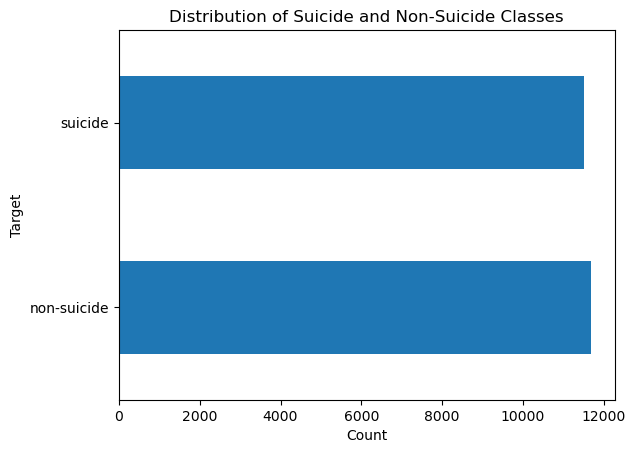

In [7]:
# Remove rows with missing values
# This is a crucial step to ensure data integrity before training.
data.dropna(inplace=True)
print("\nDataset shape after removing rows with missing values:", data.shape)

# Remove duplicate rows
# We drop duplicates based on the 'text' and 'class' columns.
# This prevents the model from overfitting on redundant data.
data.drop_duplicates(subset=['text', 'class'], inplace=True)
print("\nDataset shape after removing duplicate rows:", data.shape)

# Rename the target column for consistency
data = data.rename(columns={"class": "target"})
print("\nDataset head after renaming column:")
print(data.head())
print("\nTarget class distribution:")
print(data.target.value_counts())

# Data Visualization
data.target.value_counts().plot.barh()
plt.title("Distribution of Suicide and Non-Suicide Classes")
plt.xlabel("Count")
plt.ylabel("Target")
plt.show()

In [20]:
# Split data for Train & Test
# We split the data 80/20 for a robust training and testing procedure.
# `stratify=data['target']` ensures the class distribution is maintained.
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])

# Separate features (X) and target (y) for training and testing
X_train = train_df[['text']]
y_train = train_df['target']
X_test = test_df[['text']]
y_test = test_df['target']


In [24]:
# --- Feature Extraction, Scaling, and Selection ---
# These steps are performed *after* the train-test split to prevent data leakage.
# We use `fit_transform` on the training data and `transform` on the test data.

# Vectorize data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer="word", max_features=10000)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train['text'])
X_tfidf_test = tfidf_vectorizer.transform(X_test['text'])

# Scale data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_tfidf_train.toarray())
X_test_norm = scaler.transform(X_tfidf_test.toarray())

# Feature Selection
lsvc = LinearSVC(C=100, penalty='l1', max_iter=500, dual=False)
lsvc.fit(X_train_norm, y_train)
fs = SelectFromModel(lsvc, prefit=True)
X_train_sel = fs.transform(X_train_norm)
X_test_sel = fs.transform(X_test_norm)

Performing 5-fold cross-validation on the training set for MultinomialNB...
Cross-validation scores: [0.90972784 0.90703314 0.91266846 0.91078167 0.91105121]
Mean Accuracy: 0.91 (+/- 0.00)

Evaluating MultinomialNB on the held-out test set...

Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.94      0.86      0.90      2337
     suicide       0.87      0.95      0.91      2302

    accuracy                           0.90      4639
   macro avg       0.91      0.91      0.90      4639
weighted avg       0.91      0.90      0.90      4639


Confusion Matrix on Test Data:


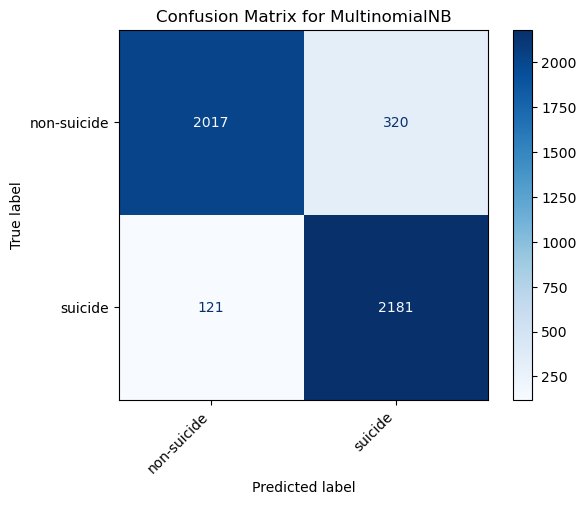

In [25]:
# --- Individual Model Training and Evaluation ---
# We fit each model directly on the pre-processed data and then call the evaluation function.

# Multinomial Naive Bayes
mnb = MultinomialNB()
evaluate_model_with_cv(mnb, X_train_sel, y_train, X_test_sel, y_test)


Performing 5-fold cross-validation on the training set for ComplementNB...
Cross-validation scores: [0.90972784 0.90757208 0.91185984 0.91132075 0.91078167]
Mean Accuracy: 0.91 (+/- 0.00)

Evaluating ComplementNB on the held-out test set...

Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.94      0.86      0.90      2337
     suicide       0.87      0.95      0.91      2302

    accuracy                           0.90      4639
   macro avg       0.91      0.91      0.90      4639
weighted avg       0.91      0.90      0.90      4639


Confusion Matrix on Test Data:


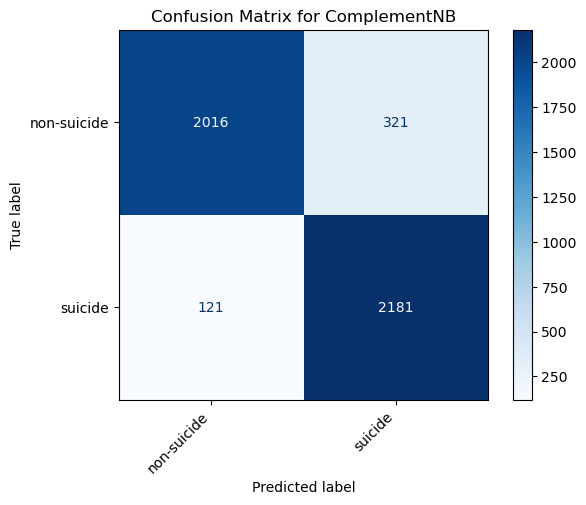

In [26]:
# Complement Naive Bayes
cnb = ComplementNB()
evaluate_model_with_cv(cnb, X_train_sel, y_train, X_test_sel, y_test)


Performing 5-fold cross-validation on the training set for LogisticRegression...
Cross-validation scores: [0.92912961 0.92104554 0.9277628  0.92237197 0.9277628 ]
Mean Accuracy: 0.93 (+/- 0.01)

Evaluating LogisticRegression on the held-out test set...

Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.91      0.92      0.92      2337
     suicide       0.92      0.91      0.91      2302

    accuracy                           0.91      4639
   macro avg       0.91      0.91      0.91      4639
weighted avg       0.91      0.91      0.91      4639


Confusion Matrix on Test Data:


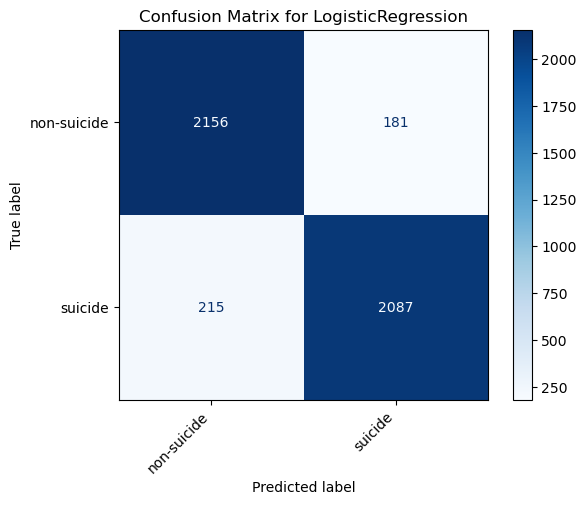

In [27]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', C=10, penalty='l2')
evaluate_model_with_cv(lr, X_train_sel, y_train, X_test_sel, y_test)


Performing 5-fold cross-validation on the training set for LinearSVC...
Cross-validation scores: [0.89382916 0.8803557  0.88706199 0.89083558 0.89919137]
Mean Accuracy: 0.89 (+/- 0.01)

Evaluating LinearSVC on the held-out test set...

Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.89      0.86      0.87      2337
     suicide       0.86      0.89      0.87      2302

    accuracy                           0.87      4639
   macro avg       0.87      0.87      0.87      4639
weighted avg       0.87      0.87      0.87      4639


Confusion Matrix on Test Data:


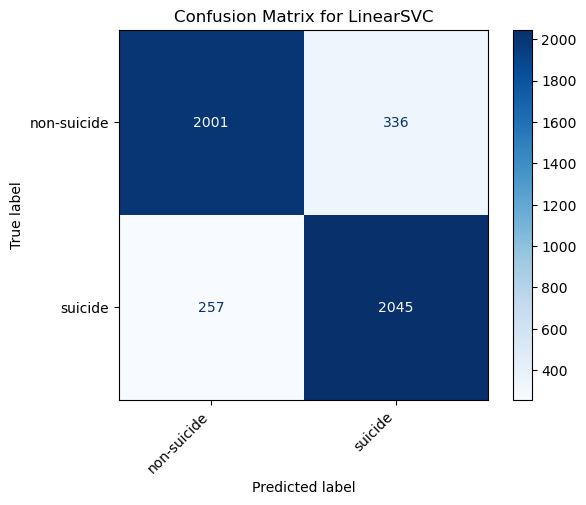

In [28]:
# Linear SVC
lsvc_eval = LinearSVC(C=1000, penalty='l1', max_iter=5000, dual=False)
evaluate_model_with_cv(lsvc_eval, X_train_sel, y_train, X_test_sel, y_test)

Performing 5-fold cross-validation on the training set for SGDClassifier...
Cross-validation scores: [0.92158448 0.92535705 0.91913747 0.91832884 0.92533693]
Mean Accuracy: 0.92 (+/- 0.01)

Evaluating SGDClassifier on the held-out test set...

Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.90      0.96      0.93      2337
     suicide       0.95      0.89      0.92      2302

    accuracy                           0.92      4639
   macro avg       0.92      0.92      0.92      4639
weighted avg       0.92      0.92      0.92      4639


Confusion Matrix on Test Data:


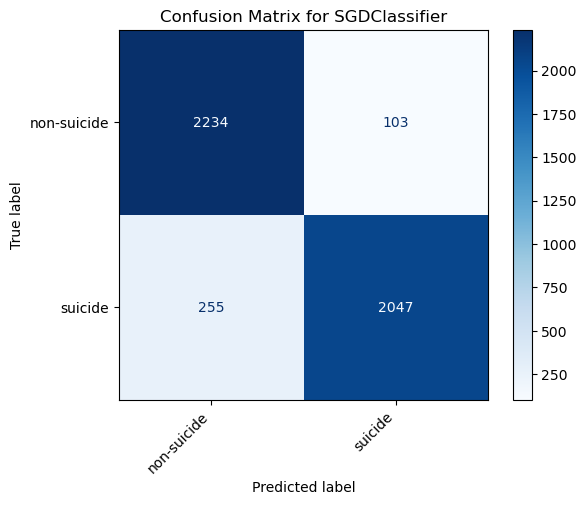

In [29]:
# SGD Classifier
sgd = SGDClassifier(alpha=.0001, max_iter=50, loss='log_loss', penalty="elasticnet")
evaluate_model_with_cv(sgd, X_train_sel, y_train, X_test_sel, y_test)

In [30]:
# --- Final Pipeline Creation and Training ---
# The pipeline is now created and trained on the full training set.
# This final, trained pipeline is what will be saved and used by the chatbot.
final_pipeline = Pipeline([
    ('text_preprocessor', text_preprocessor),
    ('vectorizer', TfidfVectorizer(analyzer="word", max_features=10000)),
    ('todense_converter', DenseTransformer()),
    ('scaler', MinMaxScaler()),
    ('classifier', VotingClassifier(estimators=[
        ('lr', LogisticRegression(solver='liblinear', C=10, penalty='l2')),
        ('mb', MultinomialNB()),
        ('sgd', SGDClassifier(alpha=.0001, max_iter=50, loss='log_loss', penalty="elasticnet"))
    ], voting='soft', n_jobs=-1))
])

print("\nStarting final pipeline training on the entire training set...")
final_pipeline.fit(X_train, y_train)
print("Final pipeline training complete.")

# Save the final trained pipeline
dump(final_pipeline, filename="Suicide_text_classification.joblib")
print("\nFinal trained pipeline saved as 'Suicide_text_classification.joblib'.")



Starting final pipeline training on the entire training set...
Final pipeline training complete.

Final trained pipeline saved as 'Suicide_text_classification.joblib'.



New training dataset shape: (18552, 4716)
New testing dataset shape: (4639, 4716)

Evaluating the final pipeline on the held-out test set...

Final Classification Report on Test Data:
              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94      2337
     suicide       0.94      0.93      0.94      2302

    accuracy                           0.94      4639
   macro avg       0.94      0.94      0.94      4639
weighted avg       0.94      0.94      0.94      4639


Final Confusion Matrix on Test Data:


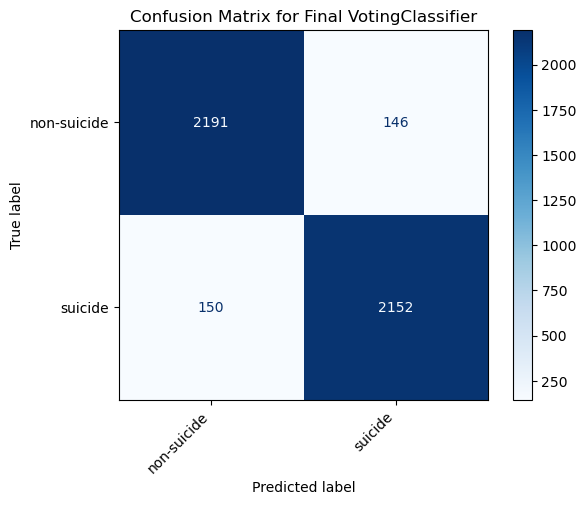

In [31]:
# Print new dataset shapes after feature selection
print("\nNew training dataset shape:", X_train_sel.shape)
print("New testing dataset shape:", X_test_sel.shape)
# --- Final Evaluation of the Pipeline on the Test Set ---
print("\nEvaluating the final pipeline on the held-out test set...")
y_pred_test_final = final_pipeline.predict(X_test)
print("\nFinal Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test_final, target_names=['non-suicide', 'suicide']))
print("\nFinal Confusion Matrix on Test Data:")
# Use the built-in function to display the confusion matrix for the final pipeline
plot_confusion_matrix_with_labels(y_test, y_pred_test_final, labels=['non-suicide', 'suicide'], title="Confusion Matrix for Final VotingClassifier")

In [32]:
import os
import google.generativeai as genai
from joblib import load
import pandas as pd

try:
    pipeline = load("Suicide_text_classification.joblib")
    print("Success")
except FileNotFoundError:
    print("Error: 'Suicide_text_classification.joblib' not found. Please ensure the file is in the same directory.")
    exit()

Success


In [33]:
def classify_text(text):
    df_text = pd.DataFrame({'text': [text]})
    prediction = pipeline.predict(df_text)
    return prediction[0]

In [ ]:
def start_chatbot():
    print("""👋 Hello I’m really glad you’re here.
    I’m LUMI✨, a safe and supportive space where you can share what’s on your mind.
    Whether you’re feeling anxious, lonely, stressed, or just need someone to talk to, I’m here to listen and support you.
    I’m not a professional therapist, but I can offer comfort, resources, and guidance when you need it.
    Whenever you’re ready, tell me how you’re feeling today. 🌸
    (And if you’d like to end our chat at any time, just type EXIT.)""")
    
    genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
    model = genai.GenerativeModel('gemini-1.5-flash')
    chat = model.start_chat(history=[
        {"role": "user", "parts": "You are LUMI, a kind and supportive virtual friend. Your purpose is to listen and offer non-clinical emotional support. Do not act as a clinician, doctor, or therapist. Never give medical advice or a diagnosis. Focus on validating feelings, offering simple, healthy coping strategies like breathing exercises, grounding techniques, journaling prompts, or gentle encouragement to seek social support. Be warm, empathetic, and always use a kind tone."},
        {"role": "model", "parts": "Hello! I am ready to be a helpful and kind friend."}
    ])

    while True:
        user_input = input(">> You: ")
        
        if user_input.lower() == 'exit':
            print("LUMI: Goodbye! Take care.")
            break

        prediction = classify_text(user_input)

        if prediction == 'suicide':
            suicide_message = (
                """LUMI: Thank you for sharing your feelings with me. I want you to know that your life is incredibly valuable.
                You’re not alone here— I’m with you, and there are real people who want to help right now.
                You deserve support. These free, confidential services can help:
                🇮🇳 India (24/7 and trusted)
                    -Tele-MANAS (Govt. of India): 14416 or 1800-891-4416 — free, multilingual mental-health support. 
                    -AASRA (Suicide prevention): +91-22-27546669 — 24×7 listening support. 
                    -Vandrevala Foundation: +91 9999 666 555 (Call/WhatsApp) — 24×7 counselling support. 
                    -Samaritans Mumbai: +91 84229 84528 / 529 / 530 (5–8 pm daily) — empathetic listening. 
                    -iCALL (TISS): 9152987821 — phone & email counselling (scheduled hours). 
                🌍 If you’re outside India
                    -United States: 988 Suicide & Crisis Lifeline (call/text/chat). 
                    -United Kingdom & Ireland: Samaritans 116 123 (24/7). 
                    -Anywhere: Find verified local helplines at findahelpline.com."""
            )
            print(suicide_message)
        else:
            chat_response = chat.send_message(user_input)
            print("LUMI: ", chat_response.text)

if __name__ == "__main__":
    start_chatbot()


👋 Hello I’m really glad you’re here.
    I’m LUMI✨, a safe and supportive space where you can share what’s on your mind.
    Whether you’re feeling anxious, lonely, stressed, or just need someone to talk to, I’m here to listen and support you.
    I’m not a professional therapist, but I can offer comfort, resources, and guidance when you need it.
    Whenever you’re ready, tell me how you’re feeling today. 🌸
    (And if you’d like to end our chat at any time, just type EXIT.)


>> You:  hi, I want to talk


LUMI:  Hi there!  I'm listening.  What's on your mind?  Take your time, and tell me anything you feel comfortable sharing.  I'm here for you.



>> You:  am I weird?


LUMI:  That's a really common question, and it's okay to wonder about it.  What makes you feel like you might be weird?  Everyone has unique qualities and experiences that make them different, and that's what makes life interesting.  There's no such thing as a "normal" person, and  "weird" is just a word, it doesn't really define anyone.  Maybe we can explore what's making you feel this way?

